In [4]:
# Set it up only when you dont have a venv already.
# from venv_script import activate_venv
# activate_venv()
# !pip install pygame
import pygame
from random import random
import numpy as np
import os
import time
import importlib
print("importing tf")
import tensorflow as tf
print("imported tf")

# from training_algorithm import Misha

importing tf
imported tf


In [5]:
print(tf.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    details = tf.config.experimental.get_device_details(gpu)
    print(f"GPU: {gpu.name}")


2.18.0


2.18.0
Ticks per game:  8192
Play the new game #1


2024-12-11 12:53:52.239 Python[10410:68339] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


Play the new game #2
1e3 ticks made in  1733919438.976925 . At this pace, getting to the update takes  28408536088.197937  seconds.
 Learn-to-play ratio:  104035166.33861549


/Users/michal.maslowski/Library/Python/3.12/lib/python/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer', 'input_layer_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(


TypeError: Invalid shape (1, 434, 576, 3) for image data

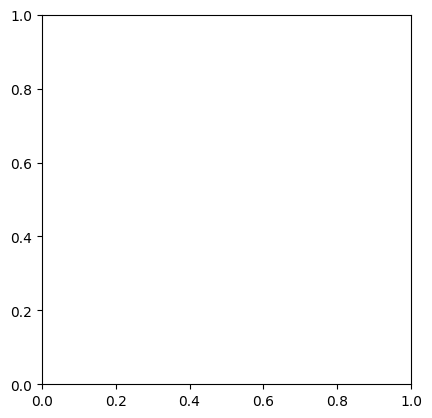

In [6]:
misha_playing = True #Bot vs human play
learning = True #Specifies whether the experience is added to the replay buffer
debug = True

import matplotlib.pyplot as plt
def plot_image(image_array): #For debug purposes    
    plt.imshow(image_array)
    plt.axis('off')  # hides the axis
    plt.show()

#if not learning:
if learning:
    from tensorflow.keras.mixed_precision import set_global_policy
    set_global_policy('mixed_float16')
    
    from training_algorithm import add_memory, train_Misha, Misha
    # time_training = np.array([])
    # time_actions = np.array([])
    # total_time = np.array([])
    # losses = np.array([])
    # times_per_action = np.array([])
    number_updates = 64 #The power of 2 that is the closest to the time contraints on Kaggle. No_of_games = 64
    ticks_per_game = 2**13 # Circa 2.25 minutes of gameplay
    ticks_per_update = 2**14
    number_of_games = (number_updates * ticks_per_update)//ticks_per_game
    update_count = 0
    print("Ticks per game: ", ticks_per_game, flush=True)


    
    
else:
    number_of_games = 2
    Misha = tf.keras.models.load_model("Misha.keras", safe_mode=False)

        

time_per_game = int(input("Please enter the length of the game, in seconds (default: 180)")) if not learning else 99999999

all_ticks = 0

def game():
    print("Play the new game #1", flush=True)

    pygame.init()    
    screen = pygame.display.set_mode((800, 600))
    global all_ticks
    import Objects
    importlib.reload(Objects)
    import Foods
    importlib.reload(Foods)
    import Player
    importlib.reload(Player)
    import Board
    importlib.reload(Board)
    import constants
    importlib.reload(constants)
    
    from Objects import Walls, Floors, CBoards, Fryers
    from Foods import Resources, Fish, Potato, Plate
    from Player import Players, Player1, Player2, player1_controls, player2_controls
    from Foods import Menu
    from constants import START_X, END_X, START_Y, END_Y
    
    print("Play the new game #2", flush=True)
    running = True
    clock = pygame.time.Clock()
    tick = 0
    game_score = 0
    
    actions = None
    former_state = None
    rewards = None
    former_rewards = 0.
    start_time = pygame.time.get_ticks()
    former_e5_time = start_time
    
    def update(actions):
        elapsed_time = (pygame.time.get_ticks() - start_time) / 1000
        if(elapsed_time < time_per_game):
            Players.update(actions)
            CBoards.update()
            Fryers.update()
            Menu.update()


        else:
            #Game finished; display a large "GAME OVER" sign over a frozen frame
            font = pygame.font.SysFont("comicsansms", 100)
            game_over_surface = font.render("GAME OVER", True, (255, 0, 0))
            game_over_rect = game_over_surface.get_rect(center=((START_X+END_X)//2, (START_Y + END_Y)//2))
            
            score_text = f"Final Score: {Menu.game_score}"
            score_surface = font.render(score_text, True, (0, 0, 0))
            score_rect = score_surface.get_rect(center=((START_X + END_X) // 2, (START_Y + END_Y) // 2 + 100))
            
            screen.blit(game_over_surface, game_over_rect)
            screen.blit(score_surface, score_rect)

    def q2idx(tick=tick, learning=learning):
        q_values = get_q_values(tick, learning)

        
        p1_values = q_values[0:5]
        p1_idx = p1_values.argmax() #Get the action from player 1 that maximizes the q value
        
        
        p1_action_possible = not (Player1.action_possible()["action"] == None)
        if (p1_idx == 4 and (not p1_action_possible)):
            p1_idx = p1_values[0:4].argmax() #Get the 2nd best action if an action is the best one and isn't possible
        
        p2_values = q_values[5:10]
        p2_idx = p2_values.argmax() #Get the action from player 1 that maximizes the q value
        
        p2_action_possible = not (Player2.action_possible()["action"] == None)
        if (p2_idx == 4 and (not p2_action_possible)):
            p2_idx = p2_values[0:4].argmax() #Get the 2nd best action if an action is the best one and isn't possible
        
        return[p1_idx, p2_idx]
    
    def idx2key(idxs):
        p1_idx = idxs[0]
        p2_idx = idxs[1]
        
        keys = [key for key in dir(pygame) if key.startswith('K_')]
        keys_dict = {getattr(pygame, key): False for key in keys}
        
        keys_dict[list(player1_controls.values())[p1_idx]] = True
        keys_dict[list(player2_controls.values())[p2_idx]] = True
        
        return keys_dict
    
    def draw():
        screen.fill((255, 255, 255)) 
        Floors.draw(screen)
        Walls.draw(screen)
        Fryers.draw(screen)
        Resources.draw(screen)
        Players.draw(screen)
        Menu.draw(screen)
    
    def get_rewards():
        '''
        Computes the total amount of rewards for the current game state. 
        Raw food needed to finish the menu is worth 5 points, 
        Cut food on the menu - 15 points 
        Fried food on the menu - 25 points
        Plate - 50 points
        Preparing a dish from the menu - half the points of giving the order 
        Fish - 500 points
        Fish and Chips - 1000 points
        '''
        
        raw_coeff = 50
        chopped_coeff = 150
        fried_coeff = 250
        plate_coeff = 500
        
        rewards = Menu.game_score*10
        
        food_categories = [("Fish", Fish), ("Potato", Potato)]
        for name, cls in food_categories:
            food_on_menu = sum([dish.ingredients_dict[name] for dish in Menu.queue])
            fried_food = len([food for food in Resources if (isinstance(food, cls) and food.fried)])
            chopped_food = len([food for food in Resources if (isinstance(food, cls) and food.chopped and not food.fried)])
            raw_food = len([food for food in Resources if (isinstance(food, cls) and not food.chopped and not food.fried)])
            
            remaining_food_on_menu = food_on_menu
            rewards += fried_coeff * min(food_on_menu, fried_food)
            
            remaining_food_on_menu -= min(food_on_menu, fried_food)
            rewards += chopped_coeff * min(chopped_food, remaining_food_on_menu) 
            
            remaining_food_on_menu -= min(chopped_food, remaining_food_on_menu) 
            rewards += raw_coeff * min(raw_food, remaining_food_on_menu)
        
        for board in CBoards:
            if ((board.resource != None) and not (board.resource.chopped)): 
                #progress = 100 -> reward is fried_coeff. progress = 0 -> reward = 0.5*(chopped_coeff-raw_coeff). Need to take into account that the coefficient for the state (raw, chopped, fried) is already counted
                #progress = 100 -> reward is chopped_coeff. progress = 0 -> reward = 0.5*(chopped_coeff-raw_coeff)
                rewards += 0.5*(chopped_coeff - raw_coeff) + 0.5*board.progress/100*(chopped_coeff - raw_coeff)
            
        for fryer in Fryers:
            if ((fryer.resource != None) and not (fryer.resource.fried)): 
                #progress = 100 -> reward is fried_coeff. progress = 0 -> reward = 0.5*(chopped_coeff-raw_coeff). Need to take into account that the coefficient for the state (raw, chopped, fried) is already counted
                rewards += 0.5*(fried_coeff - chopped_coeff) + 0.5*fryer.progress/100*(fried_coeff - chopped_coeff)
            
        
        plates = len([food for food in Resources if isinstance(food, Plate)])
        rewards += plate_coeff * min(plates, len(Menu.queue))
        
        return float(rewards)

    def get_q_values(tick=tick, learning=learning):
        def eps_function(tick):
            #Epsilon function will start at (nearly) 1 and exponentially decrease to 0.1
            return 0.1 + 0.9 * np.exp(- 1e-5/2 * tick)

        is_random = random() < eps_function(tick)
        if (is_random and learning):
            #Randomizes q-values for each move. Equivalent to picking random moves, except that action if possible is preferred
            q_values = np.random.rand(10)
            q_values[4] = q_values.max() + 1 #Set q_value of action for player 1 to max 
            q_values[9] = q_values.max() + 1 #Set q_value of action for player 2 to max 
            
        else:
            q_values = Misha.predict(get_state())
            q_values = q_values[0] #Get rid of the batch_size dimension: goes from (1, 10) to (10,) 
            
        return q_values
    
    def get_state():
        '''
        Returns the list of:
        - visual_data - normalized pixel values of the screen
        - numerical_data, containing in respective order:
            - the state of the Menu (see: Menu.get_state())
            - the state of Player 1's and Player 2's hands (see: Player.get_state())
        
        '''
        
        visual_data = pygame.surfarray.array3d(screen)
        visual_data = np.transpose(visual_data, (1, 0, 2)) #Change from width, height, color channel to height, width, color channel
        visual_data = visual_data[START_Y - Menu.height: END_Y, START_X:END_X]
        visual_data = visual_data / 255. #Normalize pixels from 0 to 1 for easier training
        visual_data = np.expand_dims(visual_data, axis=0)

        numerical_data = np.concatenate((Menu.get_state(), Player1.get_state(), Player2.get_state()))
        numerical_data = numerical_data.astype(float)
        numerical_data = np.expand_dims(numerical_data, axis=0)
        
        return [visual_data, numerical_data]

    while running:
        total_start_time = time.time()
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                break

        if(not running):
            pygame.display.quit()
            pygame.quit()
            
        debug_done = False
        
        if ((misha_playing) and (tick % 60 == 0)):
            start_time = time.time()
            state = get_state()
            action_idxs = q2idx(tick=all_ticks, learning=learning)
            actions = idx2key(action_idxs)
                
            if (learning or debug) and (tick != 0):
                rewards = get_rewards()
                add_memory(former_state[0], former_state[1], state[0], state[1], action_idxs, rewards - former_rewards)
                former_rewards = rewards
                # if (debug and tick % 180 == 0):
                #     reward = rewards - former_rewards
                #     gamma = 0.9984
                #     final_vis_state = former                    
                #     y_target = reward + np.max(Misha((final_vis_state, final_num_state))) * gamma
                
                if (tick % 100 == 0):
                    print("One action takes: ", time.time()-start_time, flush=True)
                    
                if (tick > 0 and not debug_done):
                    plot_image(state[0][0])
                    
                    
                
            former_state = state   

        
        
        tick += 1
        
        if not misha_playing:
            actions = pygame.key.get_pressed()
            if debug and (tick % 180 == 0):
                qs = get_q_values()
                print("Misha's prediction for this state: ", qs, " max: ", np.max(qs[0:5]), ", ", np.max(qs[5:10]))
                print("Actions to take: ", q2idx())
                print("")
                
                
        
        draw()    
        update(actions) 
        
        if not learning:
            pygame.display.flip()
            clock.tick(60)   
            
        if learning:
            if ((all_ticks + 1) % (ticks_per_update) == 0): 
                start_training_time = time.time()
                print("MISHA TRAINING ", ":D\n"*10)
                train_Misha() 
                # losses = np.append(losses, losses_epoch)
                # time_training = np.append(time_training, time.time()-start_training_time)
                # time_actions = np.append(time_actions, times_per_action.sum())
                # total_time = np.append(total_time, time.time() - total_start_time)
                # np.save('time_training.npy', time_training)
                # np.save('time_actions.npy', time_actions)
                # np.save('total_time.npy', total_time)
                # np.save('time_saving.npy', time_saving)
                # np.save('losses.npy', losses)
                start_time = pygame.time.get_ticks() #Reset the clock
                print("training time: ", time.time() - start_training_time, flush=True)
        
            if ((tick+1)%ticks_per_game == 0):
                running = False    
        
            if ((all_ticks) % 1e3 == 0):
                e5_time = time.time()
                print("1e3 ticks made in ", e5_time - former_e5_time, ". At this pace, getting to the update takes ", (e5_time - former_e5_time)/1e3*ticks_per_update, " seconds.\n", "Learn-to-play ratio: ", (e5_time-former_e5_time)/(1e3/60), flush=True)    
                former_e5_time = time.time()
                
            all_ticks += 1

for _ in range (number_of_games):
    start_game = time.time()
    game()    
    print("Game length: ", time.time()-start_game, flush=True)
        